In [45]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import os

if os.getcwd().split("/")[-1] != "nn_lanczos":
    os.chdir("..")
print("CWD:", os.getcwd())

CWD: /home/nadezhda/Desktop/spectral-properties-of-NN/nn_lanczos


In [47]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf


from nn_hessian import nn_hessian
from utils import *
from plot_utils import *

#### Arguments dictionary

In [48]:
args = OmegaConf.create(
    dict(
        learning_rate = 1e-3,
        batch_size = 64,
        epochs = 100,
        seed = 42
    )
)

#### Load data

In [49]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=args.batch_size)
test_dataloader = DataLoader(test_data, batch_size=args.batch_size)

#### Create model

In [50]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(28*28, 16),
            nn.Sigmoid(),
            nn.Linear(16, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sigmoid_stack(x)
        return logits

model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate)

num_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {num_params}')

Total number of parameters: 12730


In [51]:
# device to use for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [52]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # print
        if batch % 100 == 0:
            loss, current = loss.item(), batch*args.batch_size+len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Hessian spectrum before training

In [53]:
hessian_dataloader = DataLoader(training_data, batch_size=training_data.data.shape[0])
for inputs, targets in hessian_dataloader:
    break
inputs, targets = inputs.to(device), targets.to(device)

#### Create Hessian computation module

In [54]:
hessian_comp = nn_hessian(model, loss_fn, data=(inputs, targets), cuda=torch.cuda.is_available())

#### SLQ: Slow Lanczos (PyHessian's version)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:07<00:00, 13.73it/s]


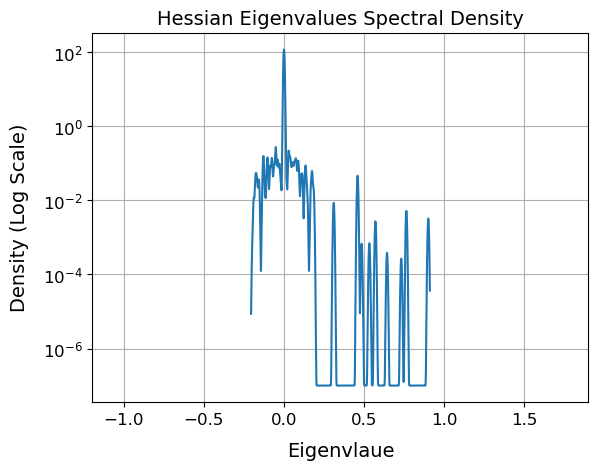

In [55]:
slq_eigenvalues_slow_lanczos_pyhessian, slq_weights_slow_lanczos_pyhessian = hessian_comp.stochastic_lanczos_quadrature("slow_pyhessian", seed=args.seed)
get_esd_plot(slq_eigenvalues_slow_lanczos_pyhessian, slq_weights_slow_lanczos_pyhessian)

#### SLQ: Slow Lanczos (Papyan's version)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:07<00:00, 13.97it/s]


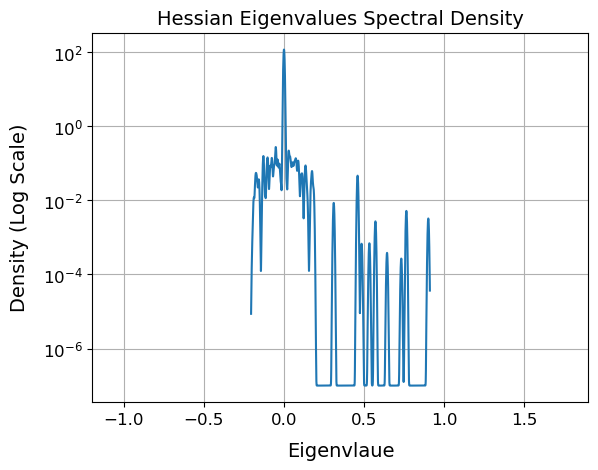

In [56]:
slq_eigenvalues_slow_lanczos_papyan, slq_weights_slow_lanczos_papyan = hessian_comp.stochastic_lanczos_quadrature("slow_papyan", seed=args.seed)
get_esd_plot(slq_eigenvalues_slow_lanczos_papyan, slq_weights_slow_lanczos_papyan)

#### SLQ: Fast Lanczos (Papyan's version)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:06<00:00, 14.88it/s]


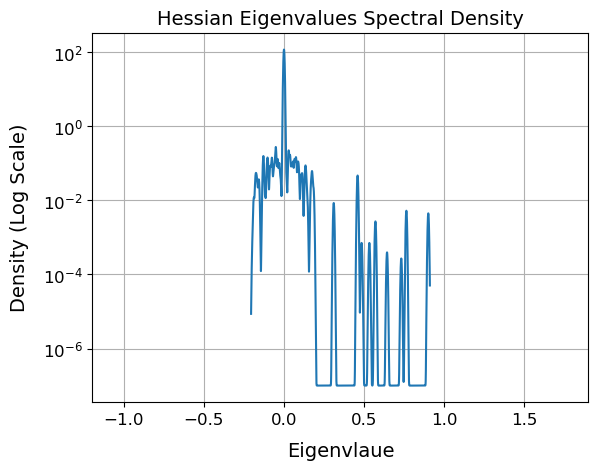

In [57]:
slq_eigenvalues_fast_lanczos_papyan, slq_weights_fast_lanczos_papyan = hessian_comp.stochastic_lanczos_quadrature("fast_papyan", seed=args.seed)
get_esd_plot(slq_eigenvalues_fast_lanczos_papyan, slq_weights_fast_lanczos_papyan)

#### Fast Lanczos (Papyan's version)

  0%|          | 2/12730 [00:00<15:00, 14.14it/s]

100%|██████████| 12730/12730 [13:58<00:00, 15.18it/s]


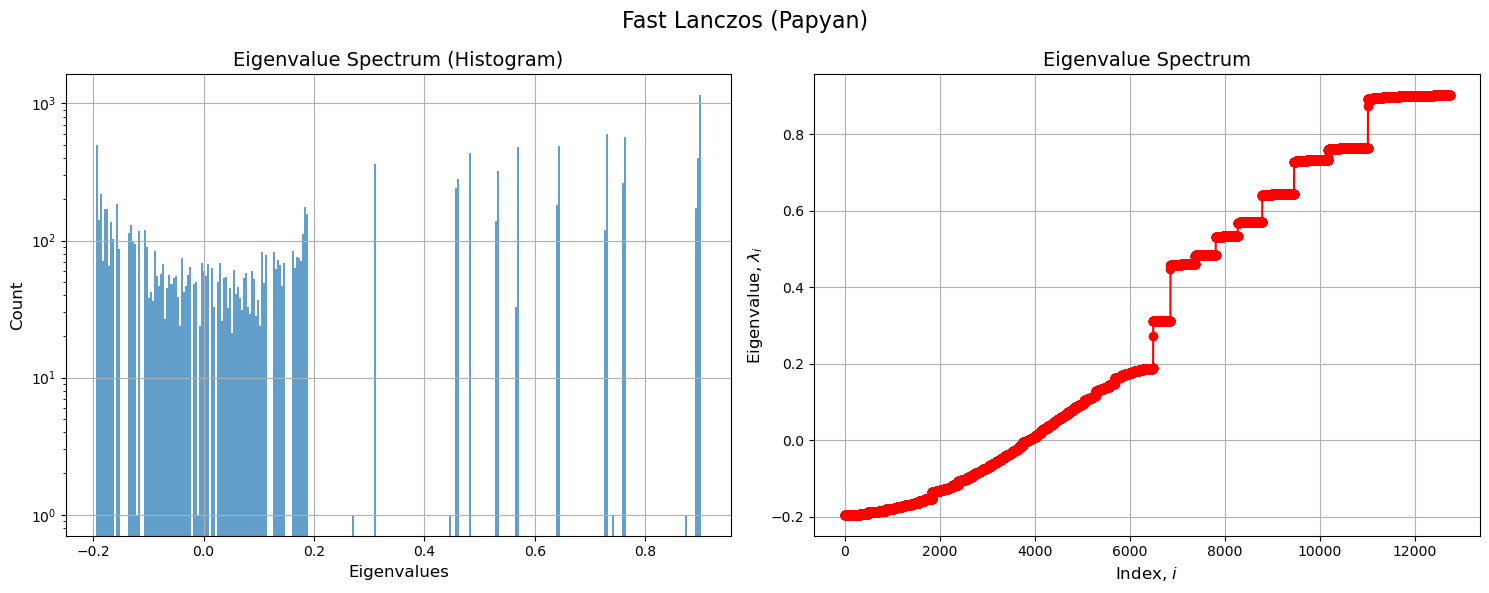

In [58]:
eigenvalues_fast_lanczos_papyan, weights_fast_lanczos_papyan = hessian_comp.fast_lanczos_papyan(iter=num_params, seed=args.seed)
plot_spectrum_combined(eigenvalues_fast_lanczos_papyan, num_bins=300, title='Fast Lanczos (Papyan)')

### Training

In [59]:
for t in range(args.epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.355461  [   64/60000]
loss: 2.385163  [ 6464/60000]
loss: 2.343516  [12864/60000]
loss: 2.288262  [19264/60000]
loss: 2.256234  [25664/60000]
loss: 2.338333  [32064/60000]
loss: 2.389444  [38464/60000]
loss: 2.314642  [44864/60000]
loss: 2.298739  [51264/60000]
loss: 2.324282  [57664/60000]
Test Error: 
 Accuracy: 13.6%, Avg loss: 2.306491 

Epoch 2
-------------------------------
loss: 2.304755  [   64/60000]
loss: 2.324028  [ 6464/60000]
loss: 2.300187  [12864/60000]
loss: 2.258165  [19264/60000]
loss: 2.242402  [25664/60000]
loss: 2.298076  [32064/60000]
loss: 2.324478  [38464/60000]
loss: 2.286364  [44864/60000]
loss: 2.269145  [51264/60000]
loss: 2.280041  [57664/60000]
Test Error: 
 Accuracy: 18.7%, Avg loss: 2.271658 

Epoch 3
-------------------------------
loss: 2.271738  [   64/60000]
loss: 2.283984  [ 6464/60000]
loss: 2.269204  [12864/60000]
loss: 2.237235  [19264/60000]
loss: 2.227872  [25664/60000]
loss: 2.267346  [32064/600

### Hessian spectrum after training

In [60]:
hessian_dataloader = DataLoader(training_data, batch_size=training_data.data.shape[0])
for inputs, targets in hessian_dataloader:
    break
inputs, targets = inputs.to(device), targets.to(device)

#### Create Hessian computation module

In [61]:
hessian_comp = nn_hessian(model, loss_fn, data=(inputs, targets), cuda=torch.cuda.is_available())

#### SLQ: Slow Lanczos (PyHessian's version)

100%|██████████| 100/100 [00:03<00:00, 29.57it/s]


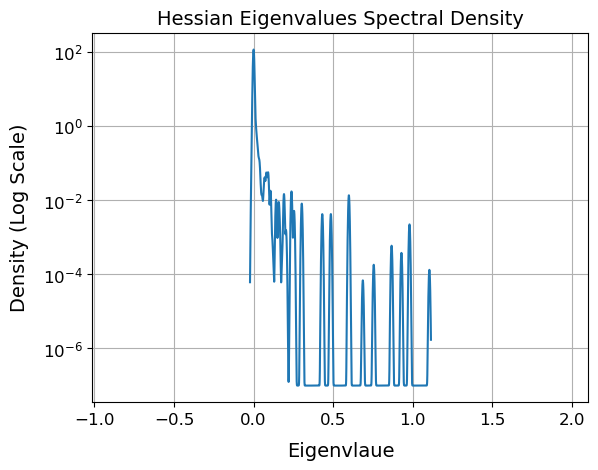

In [62]:
slq_eigenvalues_slow_lanczos_pyhessian, slq_weights_slow_lanczos_pyhessian = hessian_comp.stochastic_lanczos_quadrature("slow_pyhessian", seed=args.seed)
get_esd_plot(slq_eigenvalues_slow_lanczos_pyhessian, slq_weights_slow_lanczos_pyhessian)

#### SLQ: Slow Lanczos (Papyan's version)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 29.34it/s]


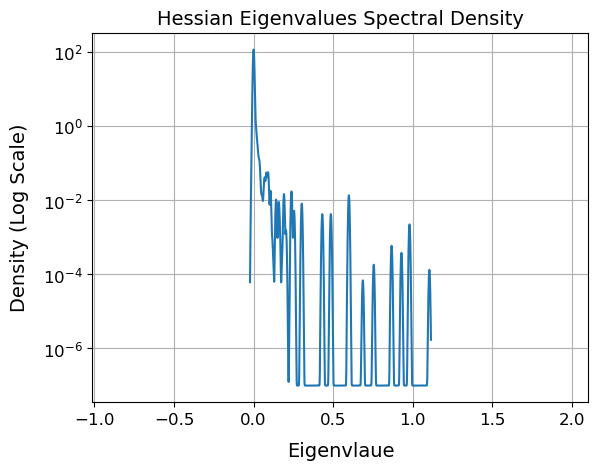

In [63]:
slq_eigenvalues_slow_lanczos_papyan, slq_weights_slow_lanczos_papyan = hessian_comp.stochastic_lanczos_quadrature("slow_papyan", seed=args.seed)
get_esd_plot(slq_eigenvalues_slow_lanczos_papyan, slq_weights_slow_lanczos_papyan)

#### SLQ: Fast Lanczos (Papyan's version)

100%|██████████| 100/100 [00:03<00:00, 30.46it/s]


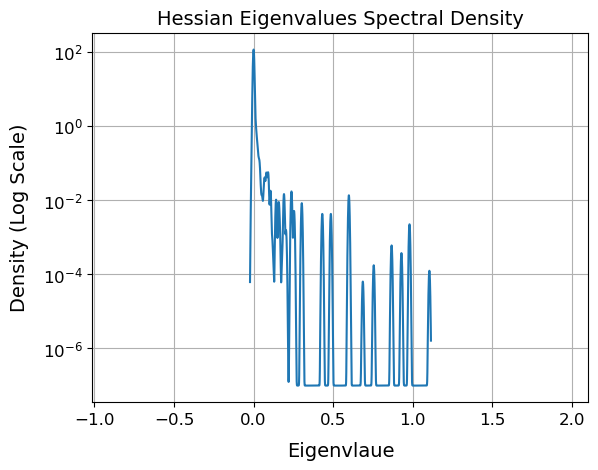

In [64]:
slq_eigenvalues_fast_lanczos_papyan, slq_weights_fast_lanczos_papyan = hessian_comp.stochastic_lanczos_quadrature("fast_papyan", seed=args.seed)
get_esd_plot(slq_eigenvalues_fast_lanczos_papyan, slq_weights_fast_lanczos_papyan)

#### Fast Lanczos (Papyan's version)

100%|██████████| 12730/12730 [07:06<00:00, 29.86it/s]


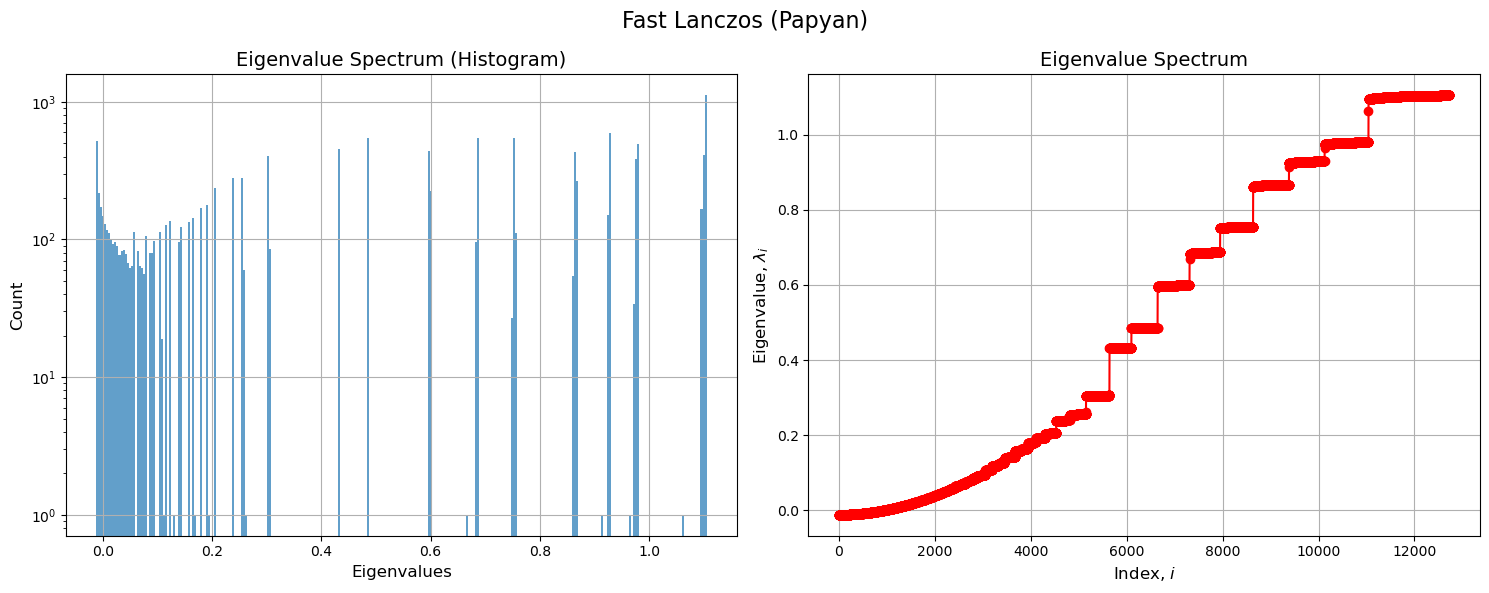

In [65]:
eigenvalues_fast_lanczos_papyan, weights_fast_lanczos_papyan = hessian_comp.fast_lanczos_papyan(iter=num_params, seed=args.seed)
plot_spectrum_combined(eigenvalues_fast_lanczos_papyan, num_bins=300, title='Fast Lanczos (Papyan)')